# Card Classification

Each image we are assessing is exactly one card. For each image we want to determine the following properties:
1) **Colour**: Red, purple or green
2) **Count**: 1, 2 or 3
3) **Shape**: Oval, diamond or squiggle
4) **Fill**: Solid, hollow or shaded

- We'll start with count so that we can then just zoom in on one shape on the card afterwards.
- Next, we will do Fill. Fill should be done before colour since the fill will determine the 
  "average" colour of the shape.
- Colour can then be done. 
- Finally, Shape.

In [239]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

def display_image(image, title=None, cmap=None, max_size=(800, 800)):
    """
    Display an image using matplotlib after resizing it to a smaller size.

    Parameters:
    - image: The image to display.
    - title: The title of the image (optional).
    - cmap: The colormap to use for displaying the image (optional).
    - max_size: The maximum size (width, height) to resize the image to (default is (400, 400)).
    """
    # Resize the image to fit within the max_size while maintaining the aspect ratio
    h, w = image.shape[:2]
    scaling_factor = min(max_size[0] / w, max_size[1] / h)
    new_size = (int(w * scaling_factor), int(h * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_AREA)

    # Convert color from BGR (OpenCV) to RGB (Matplotlib)
    if len(resized_image.shape) == 3 and resized_image.shape[2] == 3:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(4, 4))  # Adjust the figsize to make the display smaller
    if title:
        plt.title(title)
    plt.imshow(resized_image, cmap=cmap)
    plt.axis('off')
    plt.show()

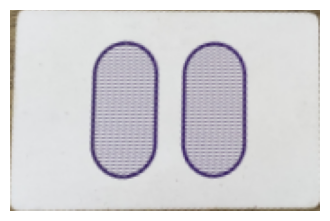

In [286]:
# Load the image using OpenCV
card = cv2.imread('./static/extracted_cards/card_4.png')
card = imutils.resize(card, width=500)

# Display the image
display_image(image=card)

## Count

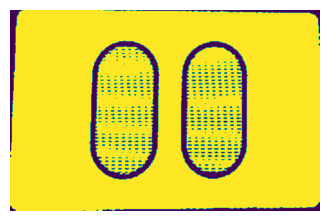

In [287]:
# Do some filtering to really make the shapes stand out.

# Apply grey scale filter
gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

# Gaussian blur the image.
blur = cv2.GaussianBlur(gray, (3, 3), 0)

# Otsu's threshold
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

display_image(thresh)

The card's Count is: 2


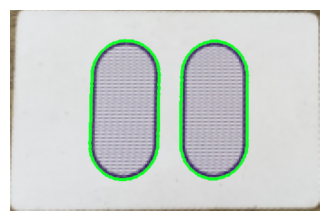

In [288]:
# Find contours and filter for cards using contour area.
# RETR_TREE: tries to find all contours.
cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_image = card.copy()

# We don't want to capture the smaller shapes, only the cards. So set a 
# threshold here. 
threshold_min_area = 400
finalContours = []
for i, contour in enumerate(cnts):
    parent_index = hierarchy[0][i][3]
    hasParent = parent_index != -1

    area = cv2.contourArea(contour)

    # Area of this contour itself is too small/large.
    if area < threshold_min_area or area > 30000: 
        continue

    # Usually we dont want to include contours that have a parent
    # unless that parent is the card itself.
    if hasParent and cv2.contourArea(cnts[parent_index]) < 30000:
        continue

    cv2.drawContours(contours_image, [contour], 0, (36,255,12), 3)

    finalContours.append(contour)

count = len(finalContours)
if count == 0:
    raise Exception("No shapes were found on the card!")

print("The card's Count is:", count)

display_image(contours_image)


## Zoom in on just one shape on the card

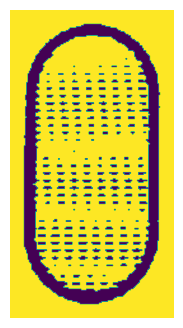

In [289]:
# Now we can just focus on one shape. So select one contour
# and zoom in on that. 
contour = finalContours[0]

x, y, w, h = cv2.boundingRect(contour)

thresh_single_shape = thresh[y-10:y+h+10, x-10:x+w+10]

display_image(thresh_single_shape)

## Fill

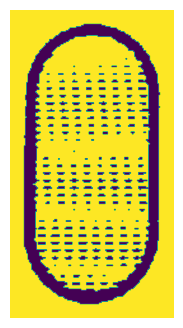

The fill is:  shaded


In [298]:
# Now we will once again find contours. This time we will use them 
# to determine the fill of the shape.
cnts, hierarchy = cv2.findContours(thresh_single_shape, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

smallCount = 0
bigContours = []
for i, contour in enumerate(cnts):
    # Check if the contour has no parent (parent index is -1), 
    # cause then we just skip it since this is the outer 
    # border of the image.
    if hierarchy[0][i][3] == -1:
        continue

    area = cv2.contourArea(contour)

    if area < 10:
        continue

    if area > 10000:
        bigContours.append(contour)
    else:
        smallCount +=1

    cv2.drawContours(thresh_single_shape, contour, -1, 255, thickness=cv2.FILLED)

display_image(thresh_single_shape)

# Let hollow be the default.
fill = "hollow"

# If the number of big contours is 1 then the shape is solid.
if len(bigContours) == 1:
    fill = "solid"

# If there are some inner speckles, then it is shaded.
elif smallCount > 10:
    fill = "shaded"


print("The fill is: ", fill)


## Colour

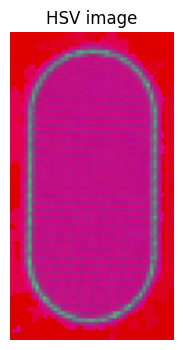

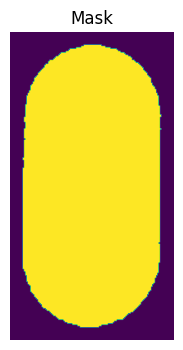

In [301]:
# We will use the fill to help out with colour classification.
card_single_shape = card[y-10:y+h+10, x-10:x+w+10]

# Convert the image to HSV for easier colour classification.
card_image_hsv = cv2.cvtColor(card_single_shape, cv2.COLOR_BGR2HSV)

display_image(card_image_hsv, title="HSV image")

if len(bigContours) == 1:
    # This case is more straight forward, we just create a single 
    # mask and find the colour of the solid shape.
    # Create a mask using the big contours.
    mask = np.zeros(card_image_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, bigContours[0], -1, 255, thickness=cv2.FILLED)

    # Mask the HSV image
    masked_hsv = cv2.bitwise_and(card_image_hsv, card_image_hsv, mask=mask)
    display_image(masked_hsv, title="Apply Mask to the HSV image")

#elif len(bigContours) ==2:
    # Here we will use the fact that the shape outline is the thickest
else:
    raise Exception("unexpected number of big contours per shape:", len(bigContours))


for i, contour in enumerate(bigContours):
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

display_image(mask, "Mask")